## Import

In [1]:
import cv2
import os
import random
import torch
import pickle
import pandas as pd

from bs4 import BeautifulSoup
from shapely.geometry import Polygon
from uuid import uuid4

from skimage.measure import label, regionprops
from skimage.feature import local_binary_pattern
from skimage.filters import threshold_multiotsu
from matplotlib import pyplot as plt
from PIL import Image
from torchmetrics.classification import BinaryJaccardIndex
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from deeplab_vandaele import remove_non_river
from mask_rcnn_coco import remove_boats
from utils import get_device, load_image, preprocessing, get_precision_recall_f1

from shadow_remover import process_image_file

from skimage.feature import graycomatrix, graycoprops

In [2]:
device = get_device()

Device: NVIDIA GeForce RTX 3070 Laptop GPU


## HSV

In [23]:
def threshold_lab(raw_img):
    hsv_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2LAB)
    
    f, axarr = plt.subplots(5, 1, figsize=(12, 36))
    
    mask = cv2.inRange(hsv_img, np.array([190, 0, 125]), np.array([250, 120, 230]))
    
    # Noise removal using Morphological open operation
    kernel = np.ones((5,5),np.uint8)
    morphOpen = cv2.dilate(mask, kernel, iterations=1)
    kernel = np.ones((3, 3),np.uint8)
    morphOpen = cv2.dilate(morphOpen, kernel, iterations=1)
    morphClose = cv2.morphologyEx(morphOpen, cv2.MORPH_CLOSE, kernel, iterations=1)
    morphOpen = cv2.morphologyEx(morphClose, cv2.MORPH_OPEN, kernel, iterations=1)
    
    axarr[0].imshow(raw_img)
    axarr[0].axis('off')
    
    axarr[1].imshow(hsv_img)
    axarr[1].axis('off')
    
    axarr[2].imshow(mask, cmap='gray')
    axarr[2].axis('off')
    
    axarr[3].imshow(morphOpen, cmap='gray')
    axarr[3].axis('off')
    
    axarr[4].imshow(raw_img)
    axarr[4].axis('off')
    
    labels = regionprops(label(morphOpen))

    bboxes = []
    for i in labels:
        minr, minc, maxr, maxc = i.bbox
        if(sum(sum((raw_img[minr:minr+maxr, minc:minc+maxc] == [255, 255, 255]).all(axis=2))) <= 75 and maxr-minr > 5 and maxc-minc > 5):
            rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1)

            axarr[4].add_patch(rect)
            
            bboxes.append([minc, minr, maxc, maxr])
            
    return torch.Tensor(bboxes)

In [20]:
def threshold_hsv(raw_img):
    hsv_img = cv2.cvtColor(raw_img, cv2.COLOR_RGB2HSV)
    
#     f, axarr = plt.subplots(5, 1, figsize=(12, 36))
    
#     (hMin = 30 , sMin = 60, vMin = 0), (hMax = 255 , sMax = 255, vMax = 120)
    mask = cv2.inRange(hsv_img, np.array([30, 60, 0]), np.array([255, 255, 120]))
    # Noise removal using Morphological open operation
    kernel = np.ones((5,5),np.uint8)
    morphOpen = cv2.dilate(mask, kernel, iterations=2)
    kernel = np.ones((3, 3),np.uint8)
    morphOpen = cv2.dilate(morphOpen, kernel, iterations=1)
    morphClose = cv2.morphologyEx(morphOpen, cv2.MORPH_CLOSE, kernel, iterations=1)
    morphOpen = cv2.morphologyEx(morphClose, cv2.MORPH_OPEN, kernel, iterations=1)
    
    plt.imshow(morphOpen)
    
#     axarr[0].imshow(raw_img)
#     axarr[0].axis('off')
    
#     axarr[1].imshow(hsv_img)
#     axarr[1].axis('off')
    
#     axarr[2].imshow(mask, cmap='gray')
#     axarr[2].axis('off')
    
#     axarr[3].imshow(morphOpen, cmap='gray')
#     axarr[3].axis('off')
    
#     axarr[4].imshow(raw_img)
#     axarr[4].axis('off')
    
    labels = regionprops(label(morphOpen))

    bboxes = []
    for i in labels:
        minr, minc, maxr, maxc = i.bbox
        if(maxr-minr > 5 and maxc-minc > 5):
            rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1)

#             axarr[4].add_patch(rect)
            
            bboxes.append([minc, minr, maxc, maxr])
            
    return torch.Tensor(bboxes)

tensor([[187.,   0., 198.,   6.],
        [  0.,   0., 379.,  86.],
        [430.,  20., 441.,  31.],
        [387.,  23., 398.,  34.],
        [428.,  37., 640.,  68.],
        [624.,  76., 638.,  88.],
        [565.,  79., 576.,  90.],
        [101.,  80., 112.,  91.],
        [  0.,  84.,  11., 104.],
        [132.,  90., 143., 101.],
        [629.,  94., 640., 105.],
        [128., 105., 161., 144.],
        [  0., 109.,   8., 120.],
        [253., 121., 270., 137.],
        [ 33., 125.,  44., 136.],
        [202., 125., 220., 138.],
        [  0., 131.,  45., 191.],
        [112., 133., 134., 153.],
        [391., 136., 407., 153.],
        [255., 144., 273., 163.],
        [232., 153., 243., 164.],
        [ 80., 156.,  91., 167.],
        [102., 156., 152., 174.],
        [304., 158., 640., 360.],
        [ 79., 176.,  90., 187.],
        [ 44., 177.,  55., 188.],
        [ 28., 185.,  49., 204.],
        [ 92., 186., 103., 197.],
        [153., 211., 175., 236.],
        [  9.,

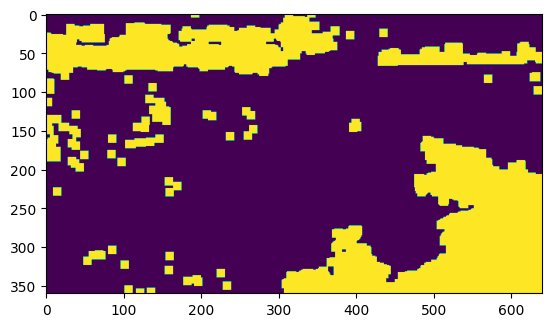

In [24]:
boxes = threshold_hsv(images[5]['image'])
print(boxes)

## Getting IoU from Ground Truth
1. River Segmentation
2. Boat Removal
3. Detected Surface Objects

In [6]:
images = []
files = ['batch1.xml', 'batch2.xml', 'batch3.xml', 'batch4.xml']

for file in files:
    with open('./segmentations/%s' % file, 'r') as f:
        soup = BeautifulSoup(f.read(), "xml")
        for img in soup.find_all('image'):
            filename = img.get('name')
            
            image = cv2.imread('./images/images/%s' % filename)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, dsize=(640, 360), interpolation=cv2.INTER_LINEAR)
            
            height = int(img.get('height'))
            width = int(img.get('width'))
            
            scaleY = 360 / height
            scaleX = 640 / width
            
            river_mask = np.zeros((360, 640))
            object_mask = np.zeros((360, 640))
            water_hyacinth_mask = np.zeros((360, 640))
            garbage_mask = np.zeros((360, 640))
            
            for polygon in img.find_all('polygon'):
                if(polygon.get('label') == 'river'):
                    coords = np.array([[round(float(p.split(',')[0]) * scaleX), round(float(p.split(',')[1]) * scaleY)] for p in polygon.get('points').split(';')])
                    
                    cv2.drawContours(river_mask, [coords], -1, 1, -1, cv2.LINE_AA)
                elif(polygon.get('label') == 'object'):
                    coords = np.array([[round(float(p.split(',')[0]) * scaleX), round(float(p.split(',')[1]) * scaleY)] for p in polygon.get('points').split(';')])
                    
                    if(polygon.find('attribute').text == 'water hyacinth'):
                        cv2.drawContours(object_mask, [coords], -1, 1, -1, cv2.LINE_AA)
                        cv2.drawContours(water_hyacinth_mask, [coords], -1, 1, -1, cv2.LINE_AA)
                        cv2.drawContours(river_mask, [coords], -1, 1, -1, cv2.LINE_AA)
                    elif(polygon.find('attribute').text == 'garbage'):
                        cv2.drawContours(object_mask, [coords], -1, 1, -1, cv2.LINE_AA)
                        cv2.drawContours(garbage_mask, [coords], -1, 1, -1, cv2.LINE_AA)
                        cv2.drawContours(river_mask, [coords], -1, 1, -1, cv2.LINE_AA)
                    elif(polygon.find('attribute').text == 'boat'):
                        cv2.drawContours(river_mask, [coords], -1, 0, -1, cv2.LINE_AA)
                    elif(polygon.find('attribute').text == 'others'):
                        cv2.drawContours(object_mask, [coords], -1, 1, -1, cv2.LINE_AA)
                        cv2.drawContours(river_mask, [coords], -1, 0, -1, cv2.LINE_AA)
            
            images.append({
                'name': filename,
                'image': image,
                'river_mask': 1 - river_mask,
                'water_hyacinth_mask': 1 - water_hyacinth_mask,
                'garbage_mask': 1 - garbage_mask,
                'object_mask': 1 - object_mask,
            })
            
len(images)

360

In [7]:
# save dictionary to pickle file
with open("ground_truth.pkl", "wb") as file:
    pickle.dump(images, file, pickle.HIGHEST_PROTOCOL)

In [8]:
with open("ground_truth.pkl", "rb") as file:
    images = pickle.load(file)
len(images)

360

In [9]:
accuracy_metric = BinaryJaccardIndex()
precision_metric = MeanAveragePrecision()

TP: 0 	 FP: 0 	 FN: 4 	 GT: 4
Precision: 0 	 Recall: 0 	 F1 score: 0
[0] 0 0 0
[  1/360]
TP: 1 	 FP: 24 	 FN: 3 	 GT: 4
Precision: 0.04 	 Recall: 0.25 	 F1 score: 0.069
[1] 0.04 0.25 0.069
[  2/360]
TP: 1 	 FP: 6 	 FN: 2 	 GT: 3
Precision: 0.143 	 Recall: 0.333 	 F1 score: 0.2
[2] 0.143 0.333 0.2
[  3/360]
TP: 0 	 FP: 0 	 FN: 3 	 GT: 3
Precision: 0 	 Recall: 0 	 F1 score: 0
[3] 0 0 0
[  4/360]
TP: 0 	 FP: 0 	 FN: 0 	 GT: 0
Precision: -1 	 Recall: -1 	 F1 score: -1
[4] -1 -1 -1
[  5/360]
TP: 1 	 FP: 39 	 FN: 2 	 GT: 3
Precision: 0.025 	 Recall: 0.333 	 F1 score: 0.047
[5] 0.025 0.333 0.047
[  6/360]
TP: 0 	 FP: 0 	 FN: 0 	 GT: 0
Precision: -1 	 Recall: -1 	 F1 score: -1
[6] -1 -1 -1
[  7/360]
TP: 0 	 FP: 0 	 FN: 2 	 GT: 2
Precision: 0 	 Recall: 0 	 F1 score: 0
[7] 0 0 0
[  8/360]
TP: 3 	 FP: 17 	 FN: 64 	 GT: 67
Precision: 0.15 	 Recall: 0.045 	 F1 score: 0.069
[8] 0.15 0.045 0.069
[  9/360]
TP: 2 	 FP: 3 	 FN: 1 	 GT: 3
Precision: 0.4 	 Recall: 0.667 	 F1 score: 0.5
[9] 0.4 0.667 0.5
[

TP: 0 	 FP: 0 	 FN: 2 	 GT: 2
Precision: 0 	 Recall: 0 	 F1 score: 0
[85] 0 0 0
[ 86/360]
TP: 0 	 FP: 0 	 FN: 14 	 GT: 14
Precision: 0 	 Recall: 0 	 F1 score: 0
[86] 0 0 0
[ 87/360]
TP: 0 	 FP: 0 	 FN: 1 	 GT: 1
Precision: 0 	 Recall: 0 	 F1 score: 0
[87] 0 0 0
[ 88/360]
TP: 0 	 FP: 0 	 FN: 0 	 GT: 0
Precision: -1 	 Recall: -1 	 F1 score: -1
[88] -1 -1 -1
[ 89/360]
TP: 0 	 FP: 0 	 FN: 2 	 GT: 2
Precision: 0 	 Recall: 0 	 F1 score: 0
[89] 0 0 0
[ 90/360]
TP: 1 	 FP: 12 	 FN: 2 	 GT: 3
Precision: 0.077 	 Recall: 0.333 	 F1 score: 0.125
[90] 0.077 0.333 0.125
[ 91/360]
TP: 0 	 FP: 0 	 FN: 1 	 GT: 1
Precision: 0 	 Recall: 0 	 F1 score: 0
[91] 0 0 0
[ 92/360]
TP: 0 	 FP: 0 	 FN: 1 	 GT: 1
Precision: 0 	 Recall: 0 	 F1 score: 0
[92] 0 0 0
[ 93/360]
TP: 0 	 FP: 0 	 FN: 1 	 GT: 1
Precision: 0 	 Recall: 0 	 F1 score: 0
[93] 0 0 0
[ 94/360]
TP: 0 	 FP: 0 	 FN: 1 	 GT: 1
Precision: 0 	 Recall: 0 	 F1 score: 0
[94] 0 0 0
[ 95/360]
TP: 0 	 FP: 0 	 FN: 1 	 GT: 1
Precision: 0 	 Recall: 0 	 F1 score: 

TP: 1 	 FP: 24 	 FN: 12 	 GT: 13
Precision: 0.04 	 Recall: 0.077 	 F1 score: 0.053
[171] 0.04 0.077 0.053
[172/360]
TP: 1 	 FP: 6 	 FN: 3 	 GT: 4
Precision: 0.143 	 Recall: 0.25 	 F1 score: 0.182
[172] 0.143 0.25 0.182
[173/360]
TP: 0 	 FP: 0 	 FN: 0 	 GT: 0
Precision: -1 	 Recall: -1 	 F1 score: -1
[173] -1 -1 -1
[174/360]
TP: 0 	 FP: 0 	 FN: 1 	 GT: 1
Precision: 0 	 Recall: 0 	 F1 score: 0
[174] 0 0 0
[175/360]
TP: 2 	 FP: 16 	 FN: 5 	 GT: 7
Precision: 0.111 	 Recall: 0.286 	 F1 score: 0.16
[175] 0.111 0.286 0.16
[176/360]
TP: 0 	 FP: 0 	 FN: 0 	 GT: 0
Precision: -1 	 Recall: -1 	 F1 score: -1
[176] -1 -1 -1
[177/360]
TP: 0 	 FP: 0 	 FN: 4 	 GT: 4
Precision: 0 	 Recall: 0 	 F1 score: 0
[177] 0 0 0
[178/360]
TP: 0 	 FP: 0 	 FN: 1 	 GT: 1
Precision: 0 	 Recall: 0 	 F1 score: 0
[178] 0 0 0
[179/360]
TP: 0 	 FP: 0 	 FN: 0 	 GT: 0
Precision: -1 	 Recall: -1 	 F1 score: -1
[179] -1 -1 -1
[180/360]
TP: 1 	 FP: 8 	 FN: 3 	 GT: 4
Precision: 0.111 	 Recall: 0.25 	 F1 score: 0.154
[180] 0.111 0

TP: 3 	 FP: 14 	 FN: 10 	 GT: 13
Precision: 0.176 	 Recall: 0.231 	 F1 score: 0.2
[254] 0.176 0.231 0.2
[255/360]
TP: 0 	 FP: 0 	 FN: 0 	 GT: 0
Precision: -1 	 Recall: -1 	 F1 score: -1
[255] -1 -1 -1
[256/360]
TP: 0 	 FP: 0 	 FN: 0 	 GT: 0
Precision: -1 	 Recall: -1 	 F1 score: -1
[256] -1 -1 -1
[257/360]
TP: 0 	 FP: 0 	 FN: 2 	 GT: 2
Precision: 0 	 Recall: 0 	 F1 score: 0
[257] 0 0 0
[258/360]
TP: 2 	 FP: 31 	 FN: 0 	 GT: 2
Precision: 0.061 	 Recall: 1.0 	 F1 score: 0.115
[258] 0.061 1.0 0.115
[259/360]
TP: 0 	 FP: 0 	 FN: 2 	 GT: 2
Precision: 0 	 Recall: 0 	 F1 score: 0
[259] 0 0 0
[260/360]
TP: 2 	 FP: 15 	 FN: 2 	 GT: 4
Precision: 0.118 	 Recall: 0.5 	 F1 score: 0.191
[260] 0.118 0.5 0.191
[261/360]
TP: 0 	 FP: 0 	 FN: 2 	 GT: 2
Precision: 0 	 Recall: 0 	 F1 score: 0
[261] 0 0 0
[262/360]
TP: 0 	 FP: 0 	 FN: 2 	 GT: 2
Precision: 0 	 Recall: 0 	 F1 score: 0
[262] 0 0 0
[263/360]
TP: 0 	 FP: 0 	 FN: 1 	 GT: 1
Precision: 0 	 Recall: 0 	 F1 score: 0
[263] 0 0 0
[264/360]
TP: 2 	 FP: 1

TP: 0 	 FP: 0 	 FN: 3 	 GT: 3
Precision: 0 	 Recall: 0 	 F1 score: 0
[338] 0 0 0
[339/360]
TP: 0 	 FP: 0 	 FN: 0 	 GT: 0
Precision: -1 	 Recall: -1 	 F1 score: -1
[339] -1 -1 -1
[340/360]
TP: 0 	 FP: 0 	 FN: 2 	 GT: 2
Precision: 0 	 Recall: 0 	 F1 score: 0
[340] 0 0 0
[341/360]
TP: 0 	 FP: 0 	 FN: 2 	 GT: 2
Precision: 0 	 Recall: 0 	 F1 score: 0
[341] 0 0 0
[342/360]
TP: 0 	 FP: 0 	 FN: 0 	 GT: 0
Precision: -1 	 Recall: -1 	 F1 score: -1
[342] -1 -1 -1
[343/360]
TP: 0 	 FP: 0 	 FN: 0 	 GT: 0
Precision: -1 	 Recall: -1 	 F1 score: -1
[343] -1 -1 -1
[344/360]
TP: 0 	 FP: 0 	 FN: 0 	 GT: 0
Precision: -1 	 Recall: -1 	 F1 score: -1
[344] -1 -1 -1
[345/360]
TP: 1 	 FP: 12 	 FN: 3 	 GT: 4
Precision: 0.077 	 Recall: 0.25 	 F1 score: 0.118
[345] 0.077 0.25 0.118
[346/360]
TP: 2 	 FP: 4 	 FN: 4 	 GT: 6
Precision: 0.333 	 Recall: 0.333 	 F1 score: 0.333
[346] 0.333 0.333 0.333
[347/360]
TP: 0 	 FP: 0 	 FN: 1 	 GT: 1
Precision: 0 	 Recall: 0 	 F1 score: 0
[347] 0 0 0
[348/360]
TP: 4 	 FP: 14 	 FN

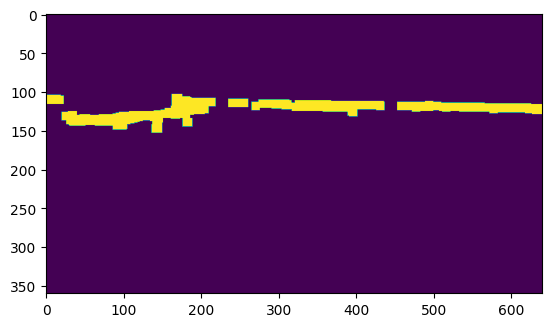

In [26]:
for i, im in enumerate(images):
    img, raw_img = preprocessing(im['image'], device)
    
    removed_river_image, river_mask = remove_non_river(img, raw_img, device)

    images[i]['river_acc'] = float(accuracy_metric(1 - torch.Tensor(river_mask), 1 - torch.Tensor(im['river_mask'])))
    images[i]['predicted_river_mask'] = river_mask
    
    pred_boxes = threshold_hsv(removed_river_image)
    actual_boxes = torch.Tensor([[mask.bbox[1], mask.bbox[0], mask.bbox[3], mask.bbox[2]] for mask in regionprops(label(1 - im['object_mask'])) if mask.bbox[3] - mask.bbox[1] > 5 and mask.bbox[2] - mask.bbox[0] > 5])

    _, _, _, precision, recall, f1 = get_precision_recall_f1(actual_boxes, pred_boxes, 0.5)
    images[i]['object_precision'] = precision
    images[i]['object_recall'] = recall
    images[i]['object_f1'] = f1
    print('[%d]' % i, precision, recall, f1)
    
#     get recall and precision

    images[i]['predicted_obj_boxes'] = pred_boxes
    images[i]['actual_obj_boxes'] = actual_boxes
    
    print('[%3d/360]' % (i + 1))

In [8]:
# save results to pickle file
with open("images_with_predicted_and_truths.pkl", "wb") as file:
    pickle.dump(images, file, pickle.HIGHEST_PROTOCOL)

### Results

In [9]:
with open("images_with_predicted_and_truths.pkl", "rb") as file:
    images = pickle.load(file)
len(images)

360

#### River Segmentation

In [27]:
##### print('========== River mAP ==========')
print('Amount with 0s:', len([im['river_acc'] for im in images]))
print('Mean with 0s:', np.mean([im['river_acc'] for im in images]))

river_less_75 = sorted([im for im in images if im['river_acc'] < 0.75], key=lambda x: x['river_acc'])
river_more_99 = sorted([im for im in images if im['river_acc'] > 0.95], key=lambda x: x['river_acc'], reverse=True)
print('Amount with less than 75%:', len(river_less_75))
print('Amount with more than 95%:', len(river_more_99))

Amount with 0s: 360
Mean with 0s: 0.9280631889899572
Amount with less than 75%: 10
Amount with more than 95%: 170


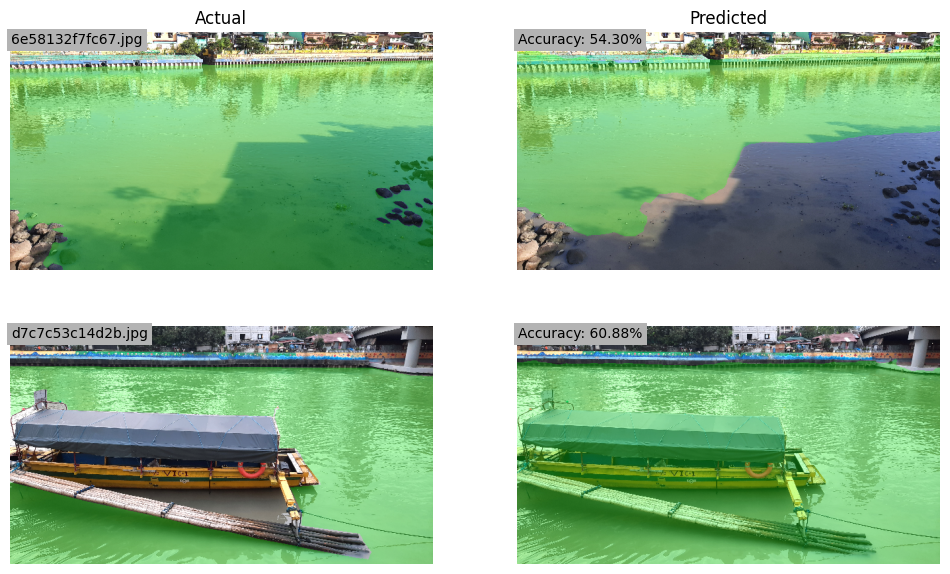

In [28]:
rows = 2

f, axarr = plt.subplots(rows, 2, figsize=(12, 7))
start = 2
for i in range(start, start + rows):
    color = np.array([0, 255, 0], dtype='uint8')
    masked_img = np.where(1 - river_less_75[i]['river_mask'][...,None], color, river_less_75[i]['image'])
    actual_img = cv2.addWeighted(river_less_75[i]['image'], 0.8, masked_img, 0.3,0)
        
    color = np.array([0, 255, 0], dtype='uint8')
    masked_img = np.where(1 - river_less_75[i]['predicted_river_mask'][...,None], color, river_less_75[i]['image'])
    predicted_img = cv2.addWeighted(river_less_75[i]['image'], 0.8, masked_img, 0.3,0)
    
    axarr[i - start, 0].imshow(actual_img)
    axarr[i - start, 1].imshow(predicted_img)
    axarr[i - start, 0].axis('off')
    axarr[i - start, 1].axis('off')
    
    axarr[i - start, 0].text(
        1.0, 
        1.0, 
        river_less_75[i]['name'], 
        fontsize='medium', 
        verticalalignment='top', 
        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
    )
    
    axarr[i - start, 1].text(
        1.0, 
        1.0, 
        'Accuracy: %.2f%%' % round(river_less_75[i]['river_acc'] * 100, 2), 
        fontsize='medium', 
        verticalalignment='top', 
        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
    )
    
    if(i == start):
        axarr[0, 0].set_title('Actual')
        axarr[0, 1].set_title('Predicted')

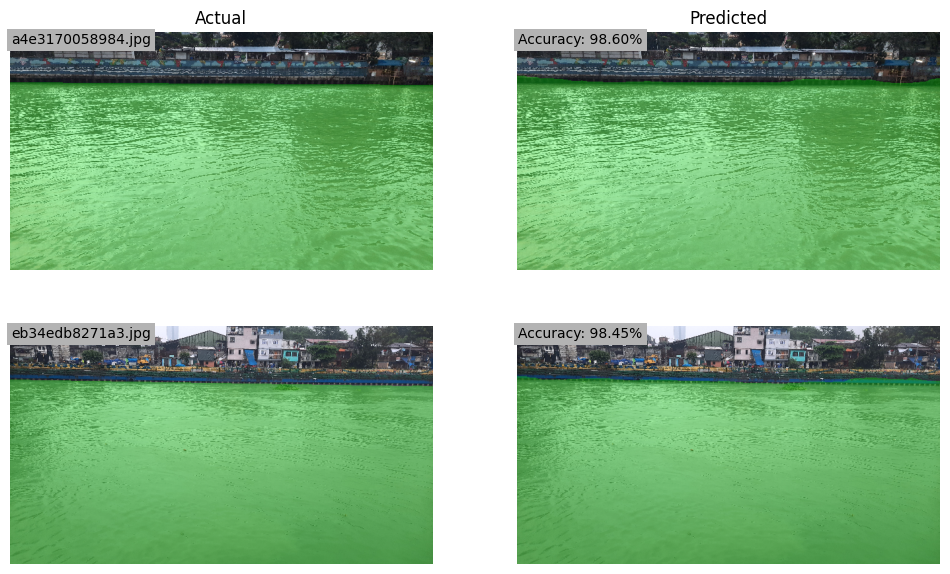

In [29]:
rows = 2

f, axarr = plt.subplots(rows, 2, figsize=(12, 7))
start = 10
for i in range(start, start + rows):
    color = np.array([0, 255, 0], dtype='uint8')
    masked_img = np.where(1 - river_more_99[i]['river_mask'][...,None], color, river_more_99[i]['image'])
    actual_img = cv2.addWeighted(river_more_99[i]['image'], 0.8, masked_img, 0.3,0)
        
    color = np.array([0, 255, 0], dtype='uint8')
    masked_img = np.where(1 - river_more_99[i]['predicted_river_mask'][...,None], color, river_more_99[i]['image'])
    predicted_img = cv2.addWeighted(river_more_99[i]['image'], 0.8, masked_img, 0.3,0)
    
    axarr[i - start, 0].imshow(actual_img)
    axarr[i - start, 1].imshow(predicted_img)
    axarr[i - start, 0].axis('off')
    axarr[i - start, 1].axis('off')
    
    axarr[i - start, 0].text(
        1.0, 
        1.0, 
        river_more_99[i]['name'], 
        fontsize='medium', 
        verticalalignment='top', 
        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
    )
    
    axarr[i - start, 1].text(
        1.0, 
        1.0, 
        'Accuracy: %.2f%%' % round(river_more_99[i]['river_acc'] * 100, 2),
        fontsize='medium', 
        verticalalignment='top', 
        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
    )
    
    if(i == start):
        axarr[0, 0].set_title('Actual')
        axarr[0, 1].set_title('Predicted')

#### Object mAP

In [30]:
print('========== Object mAP ==========')
print('Amount:', len([im['object_precision'] for im in images if im['object_precision'] != -1]))
print('Mean Precision:', np.mean([im['object_precision'] for im in images if im['object_precision'] != -1]))
print('Mean Recall:', np.mean([im['object_recall'] for im in images if im['object_recall'] != -1]))
print('Mean F1:', np.mean([im['object_f1'] for im in images if im['object_f1'] != -1]))

object_map_less_25 = sorted([im for im in images if im['object_f1'] != -1 and im['object_f1'] < 0.5], key=lambda x: x['object_f1'])
object_map_more_25 = sorted([im for im in images if im['object_f1'] != -1 and im['object_f1'] > 0.5], key=lambda x: x['object_f1'], reverse=True)
print('Amount with less than 25%:', len(object_map_less_25))
print('Amount with more than 25%:', len(object_map_more_25))

========== Object mAP ==========
Amount: 248
Mean Precision: 0.05305241935483871
Mean Recall: 0.13740322580645162
Mean F1: 0.06424193548387097
Amount with less than 25%: 243
Amount with more than 25%: 3


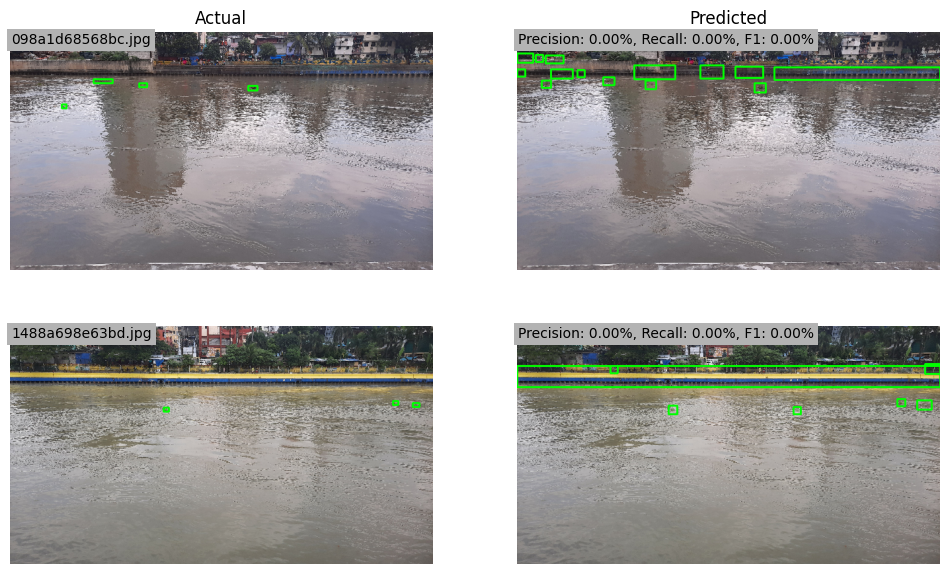

In [33]:
rows = 2

f, axarr = plt.subplots(rows, 2, figsize=(12, 7))
start = 0
for i in range(start, start + rows):
    actual_img = object_map_less_25[i]['image'].copy()
    
    for x1, y1, x2, y2 in object_map_less_25[i]['actual_obj_boxes']:
        cv2.rectangle(actual_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        
    predicted_img = object_map_less_25[i]['image'].copy()
    
    for x1, y1, x2, y2 in object_map_less_25[i]['predicted_obj_boxes']:
        cv2.rectangle(predicted_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    
    axarr[i - start, 0].imshow(actual_img)
    axarr[i - start, 1].imshow(predicted_img)
    axarr[i - start, 0].axis('off')
    axarr[i - start, 1].axis('off')
    
    
    axarr[i - start, 0].text(
        1.0, 
        1.0, 
        object_map_less_25[i]['name'], 
        fontsize='medium', 
        verticalalignment='top', 
        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
    )
    
    axarr[i - start, 1].text(
        1.0, 
        1.0, 
        'Precision: %.2f%%, Recall: %.2f%%, F1: %.2f%%' % (round(float(object_map_less_25[i]['object_precision'] * 100), 2), round(float(object_map_less_25[i]['object_recall'] * 100), 2), round(float(object_map_less_25[i]['object_f1'] * 100), 2)),
        fontsize='medium', 
        verticalalignment='top', 
        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
    )
    
    if(i == start):
        axarr[0, 0].set_title('Actual')
        axarr[0, 1].set_title('Predicted')

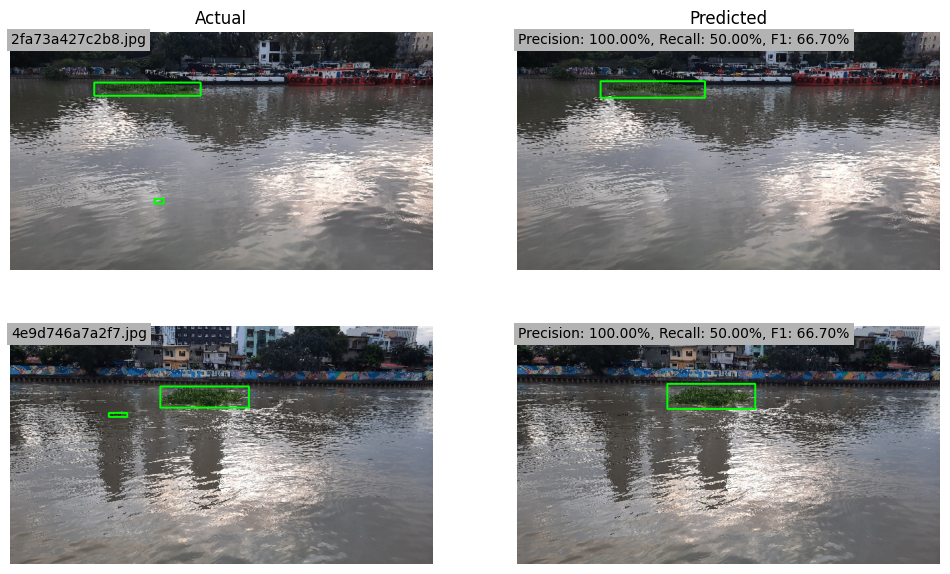

In [59]:
rows = 2

f, axarr = plt.subplots(rows, 2, figsize=(12, 7))
start = 10
for i in range(start, start + rows):
    actual_img = object_map_more_25[i]['image'].copy()
    
    for x1, y1, x2, y2 in object_map_more_25[i]['actual_obj_boxes']:
        cv2.rectangle(actual_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
        
    predicted_img = object_map_more_25[i]['image'].copy()
    
    for x1, y1, x2, y2 in object_map_more_25[i]['predicted_obj_boxes']:
        cv2.rectangle(predicted_img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
    
    axarr[i - start, 0].imshow(actual_img)
    axarr[i - start, 1].imshow(predicted_img)
    axarr[i - start, 0].axis('off')
    axarr[i - start, 1].axis('off')
    
    axarr[i - start, 0].text(
        1.0, 
        1.0, 
        object_map_more_25[i]['name'], 
        fontsize='medium', 
        verticalalignment='top', 
        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
    )
    
    axarr[i - start, 1].text(
        1.0, 
        1.0, 
        'Precision: %.2f%%, Recall: %.2f%%, F1: %.2f%%' % (round(float(object_map_more_25[i]['object_precision'] * 100), 2), round(float(object_map_more_25[i]['object_recall'] * 100), 2), round(float(object_map_more_25[i]['object_f1'] * 100), 2)),
        fontsize='medium', 
        verticalalignment='top', 
        bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0)
    )
    
    if(i == start):
        axarr[0, 0].set_title('Actual')
        axarr[0, 1].set_title('Predicted')

ideas:
- inspect Hue, Saturation, and Value
- utilize shadow removal and reflection removal

## Estimating Size

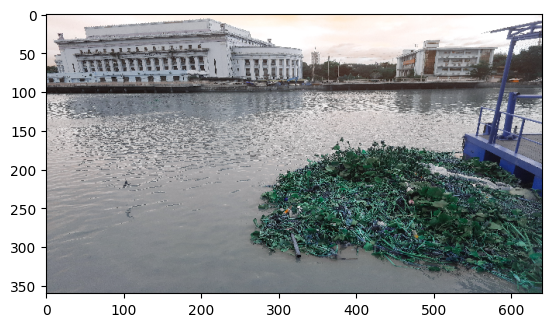

In [5]:
plt.imshow(images[2]['image'])

In [5]:
# model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in C:\Users\chris/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\chris/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master
Using cache found in C:\Users\chris/.cache\torch\hub\intel-isl_MiDaS_master


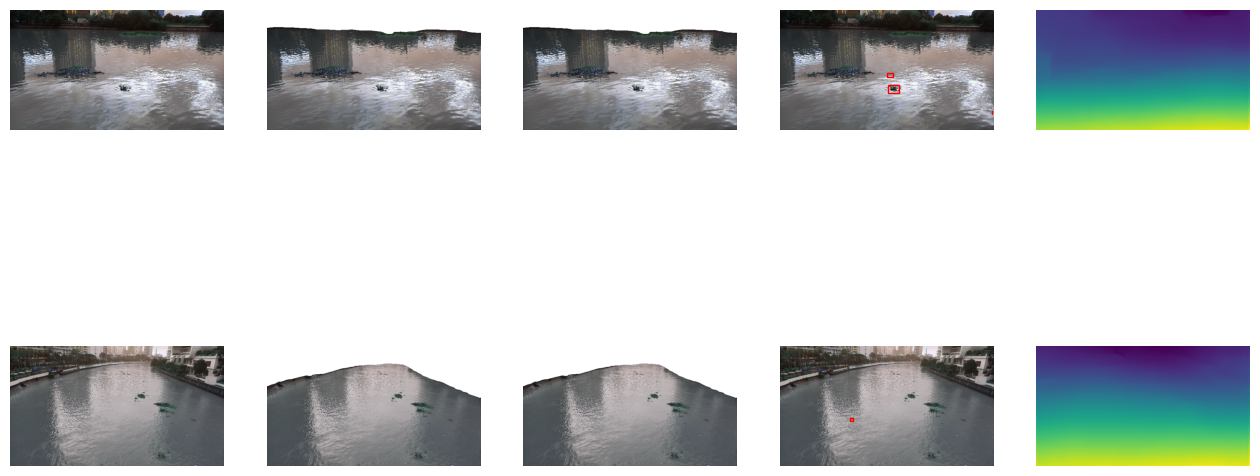

In [18]:
start = 4
end = 6

f, axarr = plt.subplots(end - start, 5, figsize=(16, 8))
for i, im in enumerate(object_map_more_25[start:end]):
    img, raw_img = preprocessing(im['image'], device)
    
    input_batch = transform(raw_img).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=raw_img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = prediction.cpu().numpy()
    
    removed_river_image, river_mask = remove_non_river(img, raw_img, device)
    removed_boat_image, boat_mask = remove_boats(removed_river_image, device)
    
    axarr[i, 0].imshow(raw_img)
    axarr[i, 1].imshow(removed_river_image)
    axarr[i, 2].imshow(removed_boat_image)
    axarr[i, 3].imshow(raw_img)
    axarr[i, 4].imshow(output)

    axarr[i, 0].axis('off')
    axarr[i, 1].axis('off')
    axarr[i, 2].axis('off')
    axarr[i, 3].axis('off')
    axarr[i, 4].axis('off')
    
    # surface object retrieval part
    blur = cv2.blur(removed_boat_image,(10, 10))
    img_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    
    kernel = np.ones((5,5),np.uint8)
    _, threshold = cv2.threshold(img_gray, 140, 255, cv2.THRESH_BINARY_INV)
    morphOpen = cv2.dilate(threshold, kernel, iterations=2)
    morphClose = cv2.morphologyEx(morphOpen, cv2.MORPH_CLOSE, kernel, iterations=1)
    morphOpen = cv2.morphologyEx(morphClose, cv2.MORPH_OPEN, kernel, iterations=1)
    
    label_im = label(morphOpen)
    
    labels = regionprops(label_im)
    
    obj_boxes = torch.Tensor([mask.bbox for mask in regionprops(label(morphOpen))])
    
    for n, L in enumerate(labels):
        minr, minc, maxr, maxc = L.bbox
        if(sum(sum(img_gray[minr:minr+maxr, minc:minc+maxc] == 255)) <= 100):
            label_im[label_im == n + 1] = 1
            rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1)

            axarr[i, 3].add_patch(rect)
        else:
            label_im[label_im == n + 1] = 0

In [17]:
def get_homography_matrix(source, destination):
    """ Calculates the entries of the Homography matrix between two sets of matching points.
    Args
    ----
        - `source`: Source points where each point is int (x, y) format.
        - `destination`: Destination points where each point is int (x, y) format.
    Returns
    ----
        - A numpy array of shape (3, 3) representing the Homography matrix.
    Raises
    ----
        - `source` and `destination` is lew than four points.
        - `source` and `destination` is of different size.
    """
    assert len(source) >= 4, "must provide more than 4 source points"
    assert len(destination) >= 4, "must provide more than 4 destination points"
    assert len(source) == len(destination), "source and destination must be of equal length"
    A = []
    b = []
    for i in range(len(source)):
        s_x, s_y = source[i]
        d_x, d_y = destination[i]
        A.append([s_x, s_y, 1, 0, 0, 0, (-d_x)*(s_x), (-d_x)*(s_y)])
        A.append([0, 0, 0, s_x, s_y, 1, (-d_y)*(s_x), (-d_y)*(s_y)])
        b += [d_x, d_y]
    A = np.array(A)
    h = np.linalg.lstsq(A, b)[0]
    h = np.concatenate((h, [1]), axis=-1)
    return np.reshape(h, (3, 3))

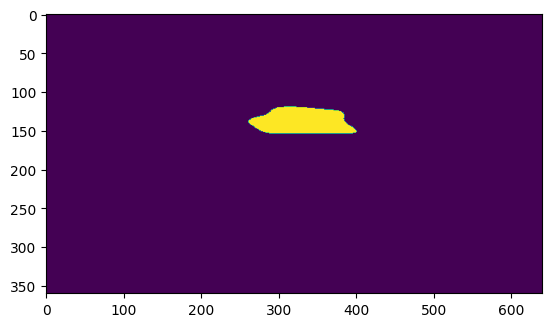

In [7]:
img, raw_img = preprocessing(images[40]['image'], device)
    
removed_river_image, river_mask = remove_non_river(img, raw_img, device)
removed_boat_image, _ = remove_boats(removed_river_image, device)
_, boat_mask = remove_boats(raw_img, device)

boat_boxes = torch.Tensor([mask.bbox for mask in regionprops(label(boat_mask))])
    
blur = cv2.blur(removed_boat_image,(10, 10))
img_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    
kernel = np.ones((5,5),np.uint8)
_, threshold = cv2.threshold(img_gray, 140, 255, cv2.THRESH_BINARY_INV)
morphOpen = cv2.dilate(threshold, kernel, iterations=2)
morphClose = cv2.morphologyEx(morphOpen, cv2.MORPH_CLOSE, kernel, iterations=1)
morphOpen = cv2.morphologyEx(morphClose, cv2.MORPH_OPEN, kernel, iterations=1)

obj_boxes = torch.Tensor([mask.bbox for mask in regionprops(label(morphOpen))])

plt.imshow(boat_mask)

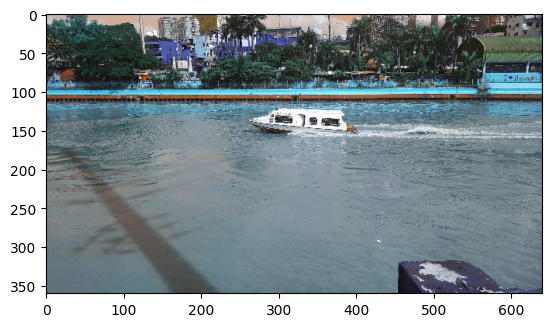

In [12]:
plt.imshow(images[40]['image'])

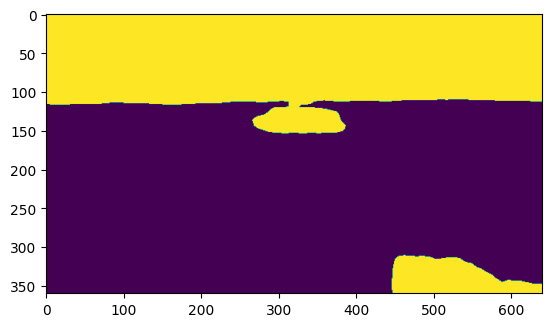

In [9]:
plt.imshow(river_mask)

(-0.5, 639.5, 359.5, -0.5)

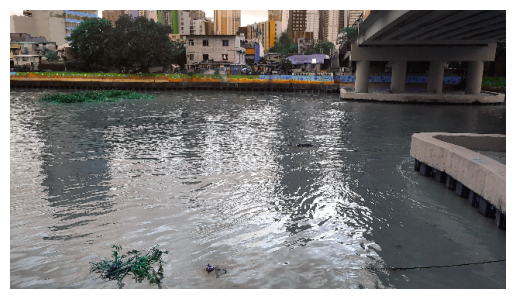

In [78]:
img, raw_img = preprocessing(object_map_more_25[0]['image'], device)
    
removed_river_image, river_mask = remove_non_river(img, raw_img, device)
removed_boat_image, _ = remove_boats(removed_river_image, device)
_, boat_mask = remove_boats(raw_img, device)

boat_boxes = torch.Tensor([mask.bbox for mask in regionprops(label(boat_mask))])
    
blur = cv2.blur(removed_boat_image,(10, 10))
img_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    
kernel = np.ones((5,5),np.uint8)
_, threshold = cv2.threshold(img_gray, 140, 255, cv2.THRESH_BINARY_INV)
morphOpen = cv2.dilate(threshold, kernel, iterations=2)
morphClose = cv2.morphologyEx(morphOpen, cv2.MORPH_CLOSE, kernel, iterations=1)
morphOpen = cv2.morphologyEx(morphClose, cv2.MORPH_OPEN, kernel, iterations=1)

obj_boxes = torch.Tensor([mask.bbox for mask in regionprops(label(morphOpen))])

plt.imshow(raw_img)
plt.axis('off')

0 80 640 93


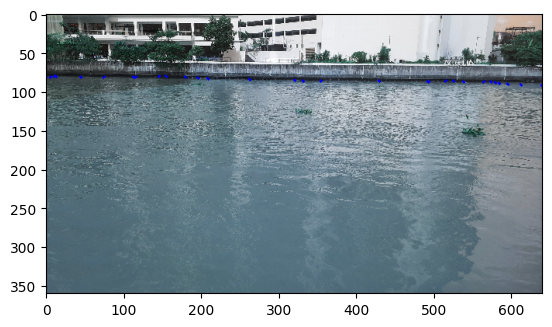

In [72]:
new_img = raw_img.copy()
idx = cv2.findContours(river_mask, cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_SIMPLE)

source_points = []
minx = None
miny = None
maxx = None
maxy = None

for points in idx[0]:
    for p in points:
        x, y = p[0]
        
        if(x == -1 or y == -1 or y == 0):
            continue
        
        source_points.append(p[0])
            
        if(minx == None):
            minx = x
        elif(x < minx):
            minx = x
            
        if(miny == None):
            miny = y
        elif(y < miny):
            miny = y
        
        if(maxx == None):
            maxx = x
        elif(x > maxx):
            maxx = x
            
        if(maxy == None):
            maxy = y
        elif(y > maxy):
            maxy = y
        
        cv2.circle(new_img, (x, y), radius=0, color=(0, 0, 255), thickness=2)
        
minx = max(minx, 0)
miny = max(miny, 0)
print(minx, miny, maxx, maxy)
plt.imshow(new_img) 

(-0.5, 639.5, 359.5, -0.5)

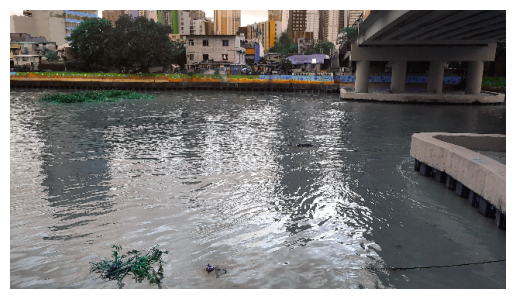

In [79]:
new_img = raw_img.copy()

top_left = [220, 100]
bot_left = [120, 260]
top_right = [420, 100]
bot_right = [520, 260]

# cv2.circle(new_img, top_left, radius=0, color=(0, 0, 255), thickness=5)
# cv2.circle(new_img, bot_left, radius=0, color=(0, 0, 255), thickness=5)
# cv2.circle(new_img, top_right, radius=0, color=(0, 0, 255), thickness=5)
# cv2.circle(new_img, bot_right, radius=0, color=(0, 0, 255), thickness=5)

plt.imshow(new_img) 
plt.axis('off')

(-0.5, 639.5, 359.5, -0.5)

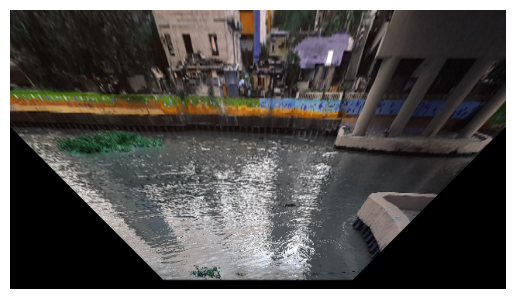

In [80]:
source_points = np.array([top_left, top_right, bot_left, bot_right], dtype=np.float32)
destination_points = np.array([[220, 150], [420, 150], [220, 310], [420, 310]], dtype=np.float32)
M = cv2.getPerspectiveTransform(source_points, destination_points)
warped = cv2.warpPerspective(new_img, M, (640, 360), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

plt.imshow(warped)
plt.axis('off')

## Estimating Location

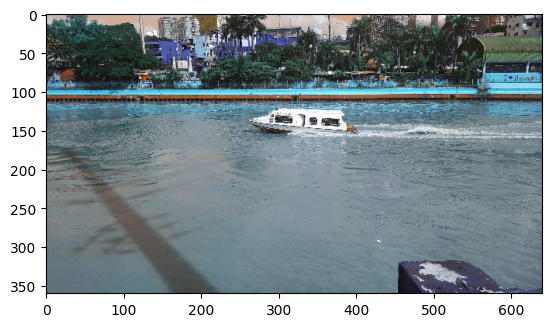

In [14]:
img, raw_img = preprocessing(images[40]['image'], device)
    
removed_river_image, river_mask = remove_non_river(img, raw_img, device)
removed_boat_image, _ = remove_boats(removed_river_image, device)
_, boat_mask = remove_boats(raw_img, device)

boat_boxes = torch.Tensor([mask.bbox for mask in regionprops(label(boat_mask))])
    
blur = cv2.blur(removed_boat_image,(10, 10))
img_gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
    
kernel = np.ones((5,5),np.uint8)
_, threshold = cv2.threshold(img_gray, 140, 255, cv2.THRESH_BINARY_INV)
morphOpen = cv2.dilate(threshold, kernel, iterations=2)
morphClose = cv2.morphologyEx(morphOpen, cv2.MORPH_CLOSE, kernel, iterations=1)
morphOpen = cv2.morphologyEx(morphClose, cv2.MORPH_OPEN, kernel, iterations=1)

obj_boxes = torch.Tensor([mask.bbox for mask in regionprops(label(morphOpen))])

plt.imshow(raw_img)

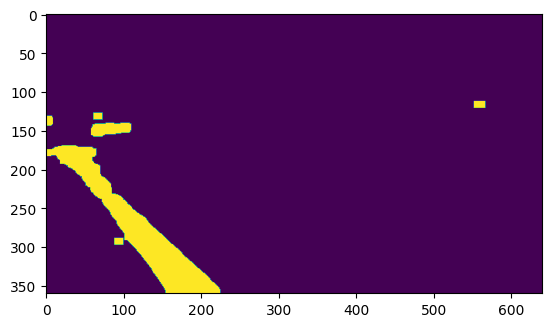

In [15]:
plt.imshow(morphOpen)

In [25]:
meter_river_width = 100
pixel_river_width = maxy - miny

meter_per_pixel = meter_river_width / pixel_river_width 
print(meter_per_pixel)
for box in obj_boxes:
    width = abs(box[0] - box[2])
    height = abs(box[1] - box[3])
    print(width * meter_per_pixel, height * meter_per_pixel)

0.4
tensor(3.6000) tensor(6.)
tensor(3.6000) tensor(4.8000)
tensor(5.2000) tensor(3.6000)
tensor(7.2000) tensor(20.8000)
tensor(76.) tensor(90.)
tensor(3.6000) tensor(4.8000)


In [20]:
pixel_river_width

250

## Removal of Shadows

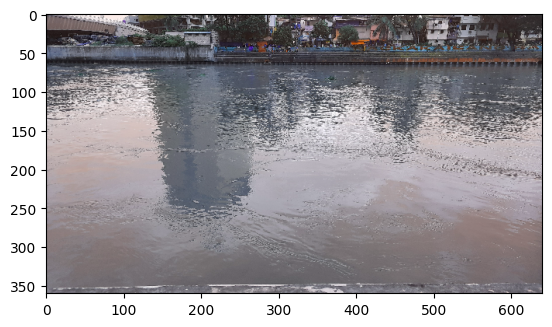

In [5]:
plt.imshow(images[0]['image'])

### Method 1 - stackoverflow

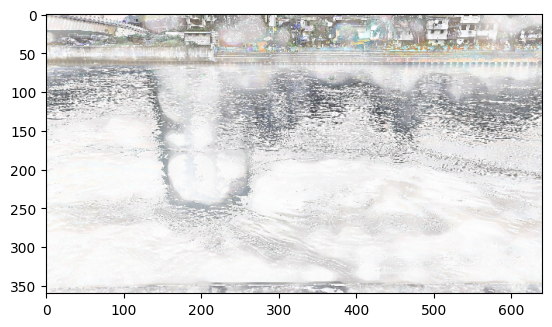

In [5]:
rgb_planes = cv2.split(images[0]['image'])

result_planes = []
result_norm_planes = []
for plane in rgb_planes:
    dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
    bg_img = cv2.medianBlur(dilated_img, 21)
    diff_img = 255 - cv2.absdiff(plane, bg_img)
    norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(diff_img)
    result_norm_planes.append(norm_img)
    
result = cv2.merge(result_planes)
result_norm = cv2.merge(result_norm_planes)

plt.imshow(result)

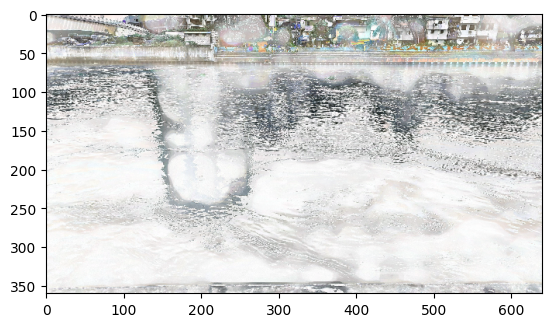

In [6]:
plt.imshow(result_norm)

### Method 2 - Github [YalimD]
https://github.com/YalimD/image_shadow_remover

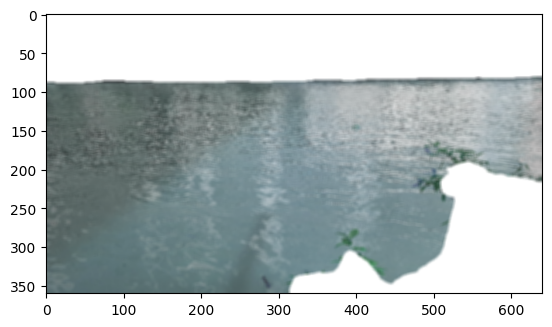

In [146]:
img, raw_img = preprocessing(images[5]['image'], device) 

removed_river_image, _ = remove_non_river(img, raw_img, device)
removed_boat_image, _ = remove_boats(removed_river_image, device)

blur = cv2.blur(removed_boat_image,(5, 5))

plt.imshow(blur)

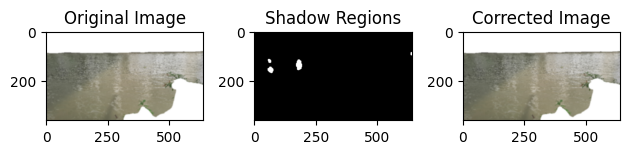

In [157]:
org_image, mask, image_clear = process_image_file(blur, ab_threshold=0, verbose=True) 

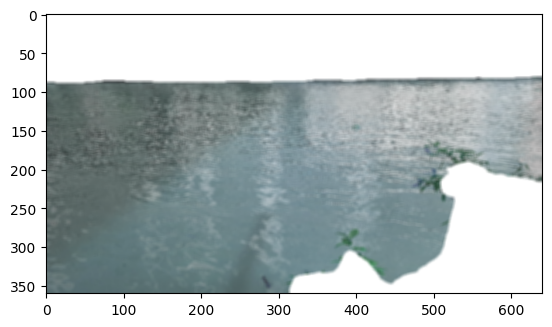

In [158]:
plt.imshow(image_clear)

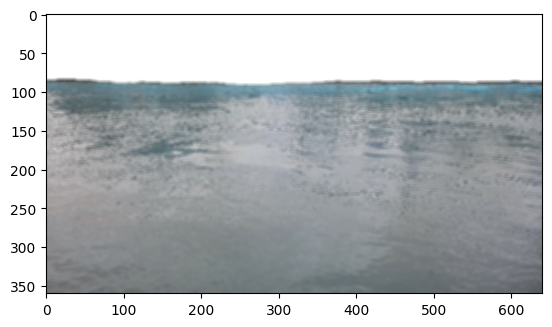

In [143]:
plt.imshow(org_image)

## Removal of Reflections

## Local Binary Pattern
https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_local_binary_pattern.html

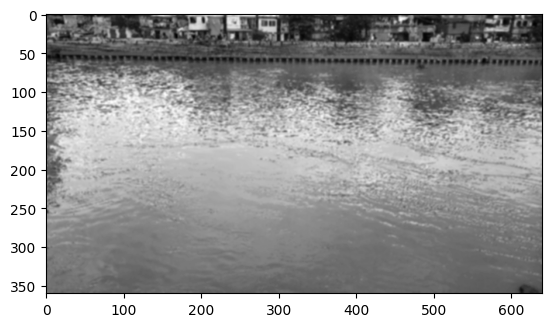

In [185]:
gray_img = cv2.cvtColor(images[7]['image'], cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)

plt.imshow(blurred, cmap='gray')

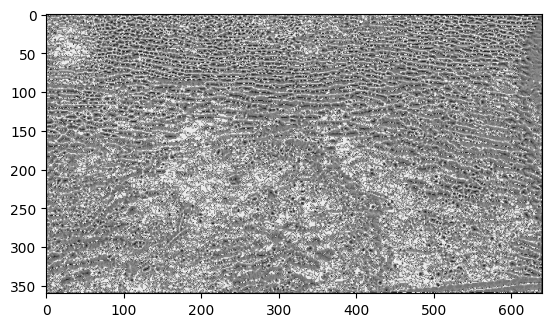

In [197]:
# type of LBP
METHOD = 'uniform'  # at most two circular 0-1 or 1-0 transitions
radius = 1  # distance between central pixels and comparison pixels
n_points = 12 * radius  # define number of comparison pixels

lbp_img = local_binary_pattern(blurred, n_points, radius, METHOD)
plt.imshow(lbp_img, cmap='gray')

In [198]:
np.unique(lbp_img)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13.])

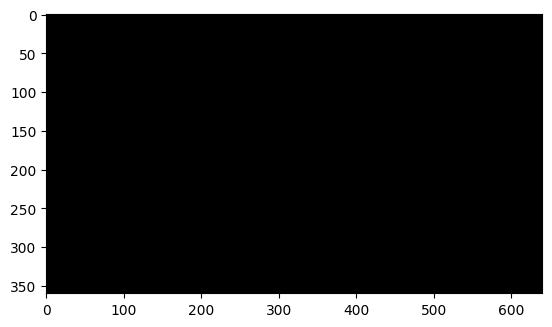

In [179]:
img = np.zeros((360, 640))

n = 2

for x, y in zip(np.where(lbp_img == n)[0], np.where(lbp_img == n)[1]):
    img[x, y] = 255
    
plt.imshow(img, cmap='gray')

In [131]:
def hist(lbp):
    '''
    Create a histogram
    :param axis: matplotlib axes
    :param lbp: ndarray local binary pattern representation of an image
    :return: matplotliob histogram
    '''
    n_bins = int(lbp.max() + 1) # number of bins based on number of different values in lbp
    return plt.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5') # np.ravel() returns a flattened 1D array

(array([0.00549913, 0.02644097, 0.00751302, 0.01148872, 0.08862413,
        0.09032552, 0.15951823, 0.25588976, 0.07190972, 0.03389323,
        0.06099392, 0.01125434, 0.13208333, 0.04456597]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14.]),
 <BarContainer object of 14 artists>)

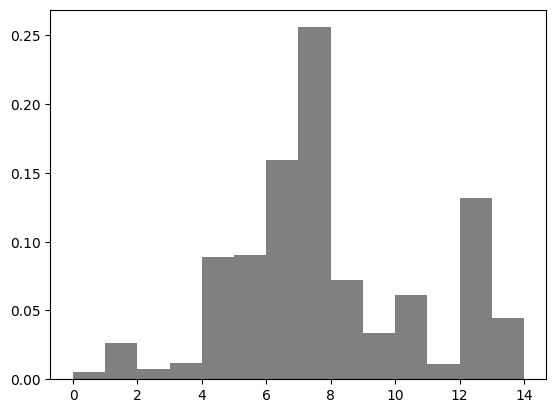

In [132]:
hist(lbp_img)

## GLCM

7.598556430446194
0.8955564002180895


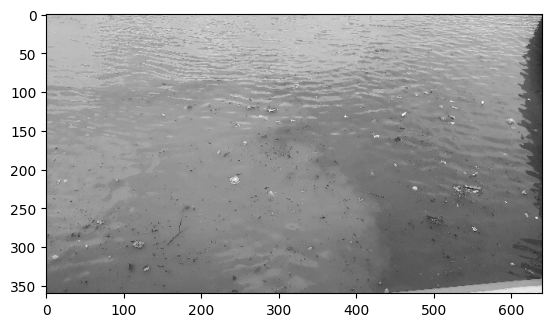

In [11]:
gray_img = cv2.cvtColor(images[8]['image'], cv2.COLOR_BGR2GRAY)

plt.imshow(gray_img, cmap='gray')

glcm = graycomatrix(gray_img, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
print(graycoprops(glcm, 'dissimilarity')[0, 0])
print(graycoprops(glcm, 'correlation')[0, 0])

## Edge Detection
https://pyimagesearch.com/2021/05/12/opencv-edge-detection-cv2-canny/

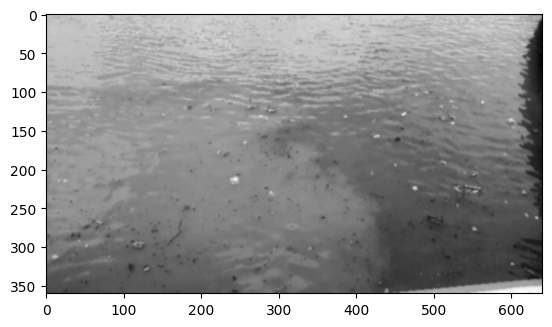

In [110]:
gray_img = cv2.cvtColor(images[8]['image'], cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)
plt.imshow(blurred, cmap='gray')

wide = cv2.Canny(blurred, 10, 200)
mid = cv2.Canny(blurred, 30, 150)
tight = cv2.Canny(blurred, 240, 250)

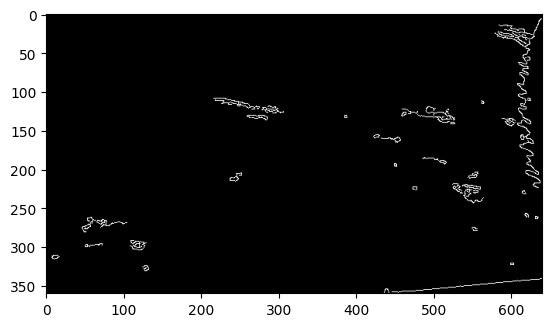

In [111]:
plt.imshow(wide, cmap='gray')

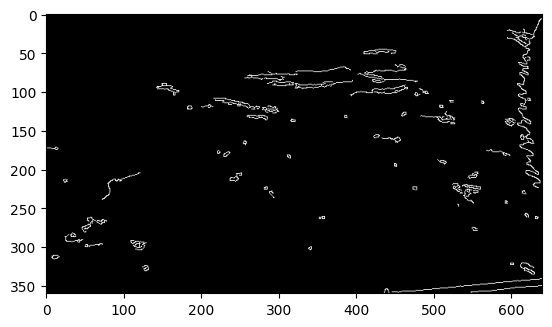

In [112]:
plt.imshow(mid, cmap='gray')

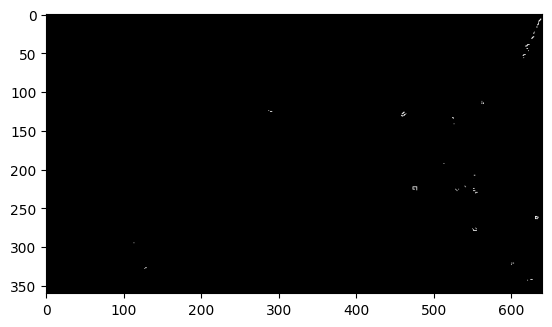

In [113]:
plt.imshow(tight, cmap='gray')

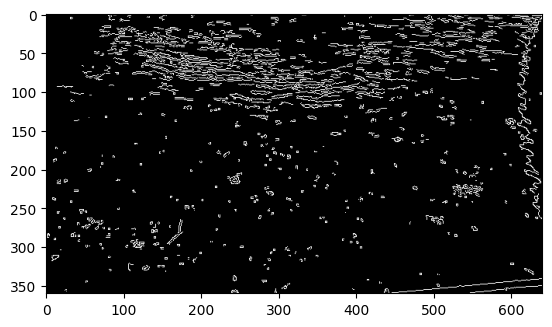

In [115]:
edges = cv2.Canny(gray_img, 100, 200)
plt.imshow(edges, cmap='gray')

## Saliency
https://pyimagesearch.com/2018/07/16/opencv-saliency-detection/

In [76]:
gray_img.shape

(360, 640)

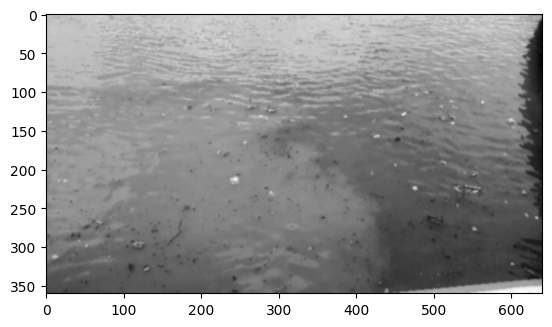

In [187]:
gray_img = cv2.cvtColor(images[8]['image'], cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray_img, (5, 5), 0)
plt.imshow(blurred, cmap='gray')

# if our saliency object is None, we need to instantiate it
saliency = cv2.saliency.StaticSaliencyFineGrained_create()
    
(success, saliencyMap) = saliency.computeSaliency(blurred)
threshMap = cv2.threshold((saliencyMap * 255).astype("uint8"), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

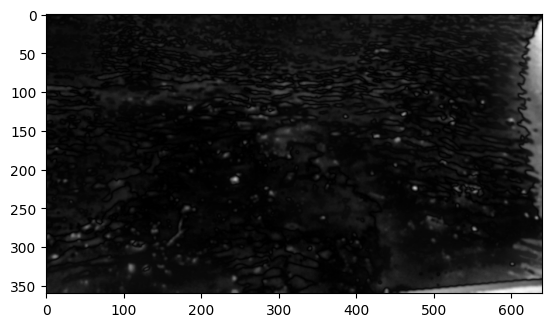

In [188]:
plt.imshow(saliencyMap, cmap='gray')

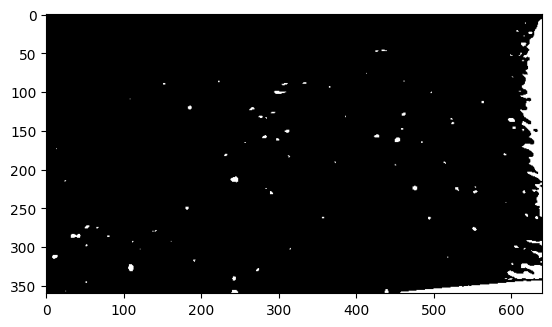

In [189]:
plt.imshow(threshMap, cmap='gray')